In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1423


In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

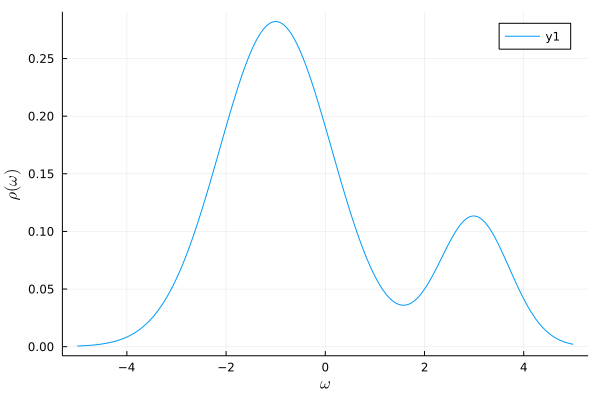

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.3)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 100
wmax = 100
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

52

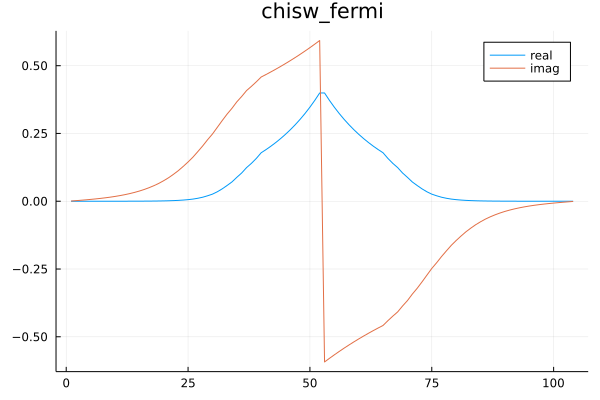

In [8]:
plot(title="chisw_fermi")
plot!(real.(gw[:]), label="real")
plot!(imag.(gw[:]), label="imag")

In [9]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

0.9999999999999998

In [10]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [11]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [12]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 15
println("N_imp $(N_imag)")
;

N_imp 31


In [29]:
@time sol = Nevanlinna.NevanlinnaSolver(hnw, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 31
H=1
Iter     Function value   Gradient norm 
     0     1.394069e-02     1.354674e-01
 * time: 0.0002231597900390625
     1     1.206891e-02     8.575569e-02
 * time: 0.2505929470062256
     2     4.456045e-03     1.189624e-01
 * time: 0.5750200748443604
     3     3.628310e-03     5.662165e-03
 * time: 0.8211250305175781
     4     3.610816e-03     5.512176e-04
 * time: 1.1515610218048096
     5     3.610754e-03     1.813940e-04
 * time: 1.5012900829315186
     6     3.610752e-03     3.976486e-05
 * time: 1.799103021621704
     7     3.610752e-03     7.187992e-06
 * time: 2.02532696723938
     8     3.610752e-03     1.244625e-06
 * time: 2.3887600898742676
     9     3.610752e-03     2.876487e-07
 * time: 2.733675003051758
    10     3.610752e-03     5.216388e-08
 * time: 2.9286391735076904
    11     3.610752e-03     1.158958e-08
 * time: 3.135496139526367
    12     3.610752e-03     2.960944e-09
 * time: 3.4832990169525146
max_theta=0.0765681565165583022979407

In [14]:
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     3.610752e-03     2.960944e-09
 * time: 0.0002999305725097656
H=2
Iter     Function value   Gradient norm 
     0     3.610752e-03     4.607507e-02
 * time: 0.0002570152282714844
     1     3.445315e-03     5.244312e-02
 * time: 0.30809712409973145
     2     2.521631e-03     6.530742e-02
 * time: 0.583158016204834
     3     1.387232e-03     5.204160e-02
 * time: 0.867685079574585
     4     1.193484e-03     1.374202e-02
 * time: 1.1063661575317383
     5     1.172533e-03     5.654424e-03
 * time: 1.468346118927002
     6     1.161579e-03     8.430653e-03
 * time: 1.8153409957885742
     7     1.115227e-03     1.339517e-02
 * time: 2.3177990913391113
     8     1.086357e-03     8.370213e-03
 * time: 2.692099094390869
     9     1.080120e-03     2.725962e-03
 * time: 3.0599679946899414
    10     1.079575e-03     7.086255e-04
 * time: 3.2945451736450195
    11     1.079531e-03     1.537229e-04
 * time: 3.5216541290283203
    12    

    39     4.326455e-05     4.006537e-09
 * time: 17.604766130447388
H=6
Iter     Function value   Gradient norm 
     0     4.326455e-05     1.758140e-03
 * time: 0.00021910667419433594
     1     4.303375e-05     2.040699e-03
 * time: 0.34902215003967285
     2     4.259803e-05     1.357907e-03
 * time: 0.719743013381958
     3     4.207568e-05     1.773743e-03
 * time: 1.0487921237945557
     4     4.144580e-05     1.876928e-03
 * time: 1.3924200534820557
     5     4.045238e-05     1.507863e-03
 * time: 1.7555291652679443
     6     3.903061e-05     1.403199e-03
 * time: 2.275499105453491
     7     3.637571e-05     2.747216e-03
 * time: 2.7811031341552734
     8     3.568594e-05     1.164392e-03
 * time: 3.156351089477539
     9     3.513092e-05     7.642041e-04
 * time: 3.662180185317993
    10     3.446864e-05     2.004159e-03
 * time: 4.20608115196228
    11     3.344292e-05     2.706035e-03
 * time: 4.773909091949463
    12     3.022588e-05     3.778006e-03
 * time: 5.29904317

    63     6.972595e-06     1.548932e-06
 * time: 39.330199003219604
    64     6.972595e-06     6.289407e-07
 * time: 39.91198396682739
    65     6.972595e-06     2.508923e-07
 * time: 40.48238205909729
    66     6.972595e-06     1.242959e-07
 * time: 41.05808091163635
    67     6.972595e-06     5.186465e-08
 * time: 41.61059808731079
    68     6.972595e-06     2.301213e-08
 * time: 42.18773794174194
    69     6.972595e-06     1.054397e-08
 * time: 42.768770933151245
    70     6.972595e-06     4.668521e-09
 * time: 43.26400589942932
H=8
Iter     Function value   Gradient norm 
     0     6.972595e-06     5.798954e-04
 * time: 0.0002899169921875
     1     6.950774e-06     6.402071e-04
 * time: 0.6844761371612549
     2     6.925523e-06     4.899421e-04
 * time: 1.2509551048278809
     3     6.893010e-06     3.841583e-04
 * time: 1.8074800968170166
     4     6.854214e-06     5.592165e-04
 * time: 2.250430107116699
     5     6.798435e-06     4.259128e-04
 * time: 2.6419551372528

    23     2.904372e-06     1.817701e-04
 * time: 13.60415506362915
    24     2.899997e-06     1.524452e-04
 * time: 14.062264919281006
    25     2.891401e-06     3.235019e-04
 * time: 14.674292087554932
    26     2.878849e-06     4.283940e-04
 * time: 15.479733943939209
    27     2.858595e-06     5.089047e-04
 * time: 16.381591081619263
    28     2.837061e-06     5.594279e-04
 * time: 17.309494972229004
    29     2.801801e-06     4.516231e-04
 * time: 18.276103973388672
    30     2.768936e-06     1.743725e-04
 * time: 19.09843897819519
    31     2.765737e-06     8.413614e-05
 * time: 19.716166973114014
    32     2.763879e-06     3.963147e-05
 * time: 20.626079082489014
    33     2.761630e-06     1.442952e-04
 * time: 21.46973705291748
    34     2.758180e-06     1.848033e-04
 * time: 22.229146003723145
    35     2.752285e-06     2.873483e-04
 * time: 22.921462059020996
    36     2.744413e-06     3.618573e-04
 * time: 23.559820890426636
    37     2.730716e-06     5.076738e

    32     1.925611e-06     6.043047e-05
 * time: 20.997604846954346
    33     1.924919e-06     9.066135e-05
 * time: 21.705830812454224
    34     1.923498e-06     1.292077e-04
 * time: 22.37862992286682
    35     1.922039e-06     1.661977e-04
 * time: 22.851032972335815
    36     1.919082e-06     2.265160e-04
 * time: 23.524890899658203
    37     1.916017e-06     2.645424e-04
 * time: 24.208260774612427
    38     1.910080e-06     3.083218e-04
 * time: 24.884326934814453
    39     1.902489e-06     2.859144e-04
 * time: 25.5938458442688
    40     1.889393e-06     1.342332e-04
 * time: 26.300137996673584
    41     1.887638e-06     6.367849e-05
 * time: 26.742793798446655
    42     1.886767e-06     3.117147e-05
 * time: 27.44798183441162
    43     1.886519e-06     2.919494e-05
 * time: 28.155936002731323
    44     1.886138e-06     5.042872e-05
 * time: 28.86687183380127
    45     1.885799e-06     5.880601e-05
 * time: 29.305856943130493
    46     1.885107e-06     9.926162e-0

    19     1.581833e-06     7.418607e-05
 * time: 11.796040773391724
    20     1.575669e-06     6.626491e-05
 * time: 12.756404876708984
    21     1.573709e-06     6.941210e-05
 * time: 13.498493909835815
    22     1.572329e-06     8.278952e-05
 * time: 14.223804950714111
    23     1.569850e-06     7.605443e-05
 * time: 14.992450952529907
    24     1.567069e-06     1.091585e-04
 * time: 15.756603002548218
    25     1.565683e-06     1.035800e-04
 * time: 16.22317385673523
    26     1.563548e-06     1.305796e-04
 * time: 16.96472477912903
    27     1.561337e-06     1.338200e-04
 * time: 17.70204496383667
    28     1.558911e-06     9.182082e-05
 * time: 18.40763282775879
    29     1.558286e-06     4.187346e-05
 * time: 18.90209197998047
    30     1.557922e-06     2.760532e-05
 * time: 19.40059781074524
    31     1.557803e-06     1.926680e-05
 * time: 19.893364906311035
    32     1.557637e-06     3.337345e-05
 * time: 20.61967182159424
    33     1.557502e-06     3.745454e-05


   140     1.456829e-06     1.194753e-04
 * time: 90.94683289527893
   141     1.456420e-06     1.444010e-04
 * time: 91.70003890991211
   142     1.455942e-06     1.607221e-04
 * time: 92.16472887992859
   143     1.455133e-06     1.935645e-04
 * time: 92.91845297813416
   144     1.454172e-06     2.136925e-04
 * time: 93.66900277137756
   145     1.452389e-06     2.523795e-04
 * time: 94.38703894615173
   146     1.450031e-06     2.694816e-04
 * time: 95.13243985176086
   147     1.444116e-06     2.572708e-04
 * time: 95.94488382339478
   148     1.432764e-06     1.227924e-04
 * time: 96.65245485305786
   149     1.431310e-06     6.420952e-05
 * time: 97.13956689834595
   150     1.430584e-06     2.919938e-05
 * time: 97.60446882247925
   151     1.430516e-06     1.759398e-05
 * time: 98.13384985923767
   152     1.430480e-06     1.180280e-05
 * time: 98.6099009513855
   153     1.430468e-06     5.164115e-06
 * time: 99.11162281036377
   154     1.430465e-06     3.456372e-06
 * time:

    94     1.399791e-06     2.826306e-05
 * time: 65.41947197914124
    95     1.399751e-06     2.885213e-05
 * time: 65.95671701431274
    96     1.399646e-06     4.697141e-05
 * time: 66.75887513160706
    97     1.399565e-06     4.801072e-05
 * time: 67.2591769695282
    98     1.399357e-06     7.102720e-05
 * time: 68.05361795425415
    99     1.399195e-06     7.341431e-05
 * time: 68.60146808624268
   100     1.398760e-06     1.028378e-04
 * time: 69.41441917419434
   101     1.398426e-06     1.062827e-04
 * time: 70.04615712165833
   102     1.397409e-06     1.255266e-04
 * time: 71.12210512161255
   103     1.396193e-06     1.167461e-04
 * time: 72.17537212371826
   104     1.393823e-06     8.039270e-05
 * time: 72.94950413703918
   105     1.393412e-06     2.361631e-05
 * time: 73.45877504348755
   106     1.393325e-06     1.181703e-05
 * time: 74.24919104576111
   107     1.393309e-06     7.949618e-06
 * time: 74.75343298912048
   108     1.393296e-06     5.138258e-06
 * time:

    20     1.355030e-06     1.968327e-05
 * time: 14.170364141464233
    21     1.354920e-06     1.151188e-05
 * time: 14.951942205429077
    22     1.354828e-06     1.131708e-05
 * time: 15.78257703781128
    23     1.354586e-06     2.075416e-05
 * time: 16.61088800430298
    24     1.354507e-06     1.110773e-05
 * time: 17.435060024261475
    25     1.354428e-06     1.379158e-05
 * time: 18.230653047561646
    26     1.353837e-06     2.641656e-05
 * time: 19.3056321144104
    27     1.353461e-06     4.674982e-05
 * time: 20.164226055145264
    28     1.353294e-06     3.179408e-05
 * time: 20.71539807319641
    29     1.353049e-06     2.417722e-05
 * time: 21.533810138702393
    30     1.352771e-06     1.961833e-05
 * time: 22.36435604095459
    31     1.352711e-06     1.436666e-05
 * time: 22.894760131835938
    32     1.352623e-06     2.439794e-05
 * time: 23.727342128753662
    33     1.352556e-06     2.581210e-05
 * time: 24.546650171279907
    34     1.352447e-06     3.124556e-05

   141     1.345352e-06     2.044089e-06
 * time: 100.16685700416565
   142     1.345352e-06     2.635756e-06
 * time: 100.76446008682251
   143     1.345351e-06     3.496915e-06
 * time: 101.31430411338806
   144     1.345350e-06     4.207006e-06
 * time: 101.87009119987488
   145     1.345349e-06     5.297498e-06
 * time: 102.43505811691284
   146     1.345347e-06     6.092761e-06
 * time: 102.9962739944458
   147     1.345346e-06     7.293781e-06
 * time: 103.51353621482849
   148     1.345344e-06     8.275756e-06
 * time: 104.090576171875
   149     1.345341e-06     9.830193e-06
 * time: 104.61730599403381
   150     1.345339e-06     1.107941e-05
 * time: 105.1700451374054
   151     1.345335e-06     1.296910e-05
 * time: 105.71720099449158
   152     1.345331e-06     1.443965e-05
 * time: 106.2522521018982
   153     1.345326e-06     1.667105e-05
 * time: 106.79671216011047
   154     1.345320e-06     1.844176e-05
 * time: 107.35321998596191
   155     1.345312e-06     2.115381e-0

   261     1.330309e-06     1.865299e-06
 * time: 174.68471121788025
   262     1.330309e-06     1.488275e-06
 * time: 175.51427507400513
   263     1.330308e-06     6.834497e-07
 * time: 176.0511782169342
   264     1.330308e-06     5.621209e-07
 * time: 176.87767601013184
   265     1.330308e-06     2.501385e-07
 * time: 177.4172031879425
   266     1.330308e-06     2.117324e-07
 * time: 178.23052310943604
   267     1.330308e-06     1.021350e-07
 * time: 178.78185105323792
   268     1.330308e-06     8.506719e-08
 * time: 179.5754120349884
   269     1.330308e-06     3.743403e-08
 * time: 180.14511013031006
   270     1.330308e-06     3.107278e-08
 * time: 180.96450901031494
   271     1.330308e-06     1.386360e-08
 * time: 181.52188205718994
   272     1.330308e-06     1.213718e-08
 * time: 182.371356010437
   273     1.330308e-06     5.478554e-09
 * time: 182.91462111473083
H=14
Iter     Function value   Gradient norm 
     0     1.330308e-06     1.998412e-05
 * time: 0.0002620220

   107     1.326332e-06     1.372666e-06
 * time: 83.49097204208374
   108     1.326331e-06     1.908102e-06
 * time: 84.06431889533997
   109     1.326331e-06     2.254285e-06
 * time: 84.63935494422913
   110     1.326330e-06     2.928021e-06
 * time: 85.21001601219177
   111     1.326330e-06     3.353056e-06
 * time: 85.74640989303589
   112     1.326329e-06     4.019551e-06
 * time: 86.3778190612793
   113     1.326328e-06     4.616199e-06
 * time: 86.90591788291931
   114     1.326327e-06     5.415043e-06
 * time: 87.47790002822876
   115     1.326326e-06     6.170899e-06
 * time: 88.03564286231995
   116     1.326325e-06     7.065258e-06
 * time: 88.65210103988647
   117     1.326323e-06     7.948694e-06
 * time: 89.22362804412842
   118     1.326321e-06     8.933715e-06
 * time: 89.83943605422974
   119     1.326319e-06     9.939682e-06
 * time: 90.39765095710754
   120     1.326317e-06     1.104127e-05
 * time: 90.99617004394531
   121     1.326314e-06     1.219499e-05
 * time:

   227     1.320855e-06     2.765763e-07
 * time: 170.55353999137878
   228     1.320855e-06     1.135525e-07
 * time: 171.14282989501953
   229     1.320855e-06     1.155401e-07
 * time: 172.0361030101776
   230     1.320855e-06     4.630242e-08
 * time: 172.6300539970398
   231     1.320855e-06     7.145819e-08
 * time: 173.50000500679016
   232     1.320855e-06     3.526990e-08
 * time: 174.06455898284912
   233     1.320855e-06     9.753327e-08
 * time: 174.8803050518036
   234     1.320855e-06     7.485371e-08
 * time: 175.4434778690338
   235     1.320855e-06     1.499621e-07
 * time: 176.29418992996216
   236     1.320855e-06     1.358538e-07
 * time: 176.8537299633026
   237     1.320855e-06     2.376161e-07
 * time: 177.710510969162
   238     1.320855e-06     2.252995e-07
 * time: 178.2509570121765
   239     1.320855e-06     3.488830e-07
 * time: 179.098965883255
   240     1.320855e-06     3.330800e-07
 * time: 179.69079208374023
   241     1.320855e-06     4.978574e-07
 * 

    47     1.317789e-06     1.352909e-05
 * time: 37.44317388534546
    48     1.317782e-06     1.394489e-05
 * time: 38.05112981796265
    49     1.317768e-06     1.659562e-05
 * time: 38.97727680206299
    50     1.317758e-06     1.697283e-05
 * time: 39.616620779037476
    51     1.317730e-06     1.874705e-05
 * time: 40.536072969436646
    52     1.317678e-06     1.552861e-05
 * time: 41.459450006484985
    53     1.317632e-06     1.557901e-05
 * time: 42.38655090332031
    54     1.317604e-06     7.273392e-06
 * time: 42.96163487434387
    55     1.317592e-06     5.582164e-06
 * time: 43.5721538066864
    56     1.317587e-06     2.839592e-06
 * time: 44.1841778755188
    57     1.317582e-06     5.325262e-06
 * time: 45.113258838653564
    58     1.317579e-06     3.866459e-06
 * time: 45.73564291000366
    59     1.317576e-06     5.914599e-06
 * time: 46.61807298660278
    60     1.317573e-06     5.753535e-06
 * time: 47.217031955718994
    61     1.317569e-06     8.275438e-06
 * t

   167     1.316963e-06     5.413315e-06
 * time: 128.73785185813904
   168     1.316955e-06     6.533135e-06
 * time: 129.67865300178528
   169     1.316952e-06     1.707197e-06
 * time: 130.336660861969
   170     1.316951e-06     1.663859e-06
 * time: 131.02391290664673
   171     1.316951e-06     1.071217e-06
 * time: 131.61742281913757
   172     1.316951e-06     1.051953e-06
 * time: 132.53529691696167
   173     1.316951e-06     4.260110e-07
 * time: 133.18244791030884
   174     1.316951e-06     6.069967e-07
 * time: 134.14100289344788
   175     1.316951e-06     2.859522e-07
 * time: 134.72335982322693
   176     1.316951e-06     7.185178e-07
 * time: 135.59878587722778
   177     1.316950e-06     4.587713e-07
 * time: 136.16187191009521
   178     1.316950e-06     9.708118e-07
 * time: 137.05958890914917
   179     1.316950e-06     8.165160e-07
 * time: 137.68994879722595
   180     1.316950e-06     1.400100e-06
 * time: 138.5533528327942
   181     1.316950e-06     1.298414e

   287     1.314725e-06     1.059707e-07
 * time: 218.61514592170715
   288     1.314725e-06     9.581026e-08
 * time: 219.43121886253357
   289     1.314725e-06     4.928545e-08
 * time: 220.21505999565125
   290     1.314725e-06     4.806530e-08
 * time: 220.9651608467102
   291     1.314725e-06     2.235617e-08
 * time: 221.64479994773865
   292     1.314725e-06     3.127493e-08
 * time: 222.22283697128296
   293     1.314725e-06     1.568174e-08
 * time: 222.82049179077148
   294     1.314725e-06     3.070257e-08
 * time: 223.67227387428284
   295     1.314725e-06     2.418492e-08
 * time: 224.30362796783447
   296     1.314725e-06     4.233549e-08
 * time: 225.2263889312744
   297     1.314725e-06     3.914490e-08
 * time: 225.78427696228027
   298     1.314725e-06     5.847363e-08
 * time: 226.6612207889557
   299     1.314725e-06     5.692472e-08
 * time: 227.2656078338623
   300     1.314725e-06     7.767696e-08
 * time: 228.12719678878784
   301     1.314725e-06     7.740694e-

   407     1.313656e-06     4.022008e-08
 * time: 306.6207799911499
   408     1.313656e-06     3.488996e-08
 * time: 307.1879708766937
   409     1.313656e-06     1.899471e-08
 * time: 307.8236289024353
   410     1.313656e-06     1.761271e-08
 * time: 308.43253684043884
   411     1.313656e-06     9.499666e-09
 * time: 309.04504895210266
H=16
Iter     Function value   Gradient norm 
     0     1.313656e-06     8.124768e-06
 * time: 0.0002129077911376953
     1     1.313653e-06     8.003133e-06
 * time: 0.718303918838501
     2     1.313651e-06     5.442707e-06
 * time: 1.3520538806915283
     3     1.313649e-06     5.021444e-06
 * time: 1.9511799812316895
     4     1.313647e-06     4.052442e-06
 * time: 2.6667098999023438
     5     1.313643e-06     3.618716e-06
 * time: 3.2520058155059814
     6     1.313639e-06     4.361524e-06
 * time: 3.865432024002075
     7     1.313635e-06     3.755310e-06
 * time: 4.482683897018433
     8     1.313630e-06     4.788915e-06
 * time: 5.11122393

   115     1.312837e-06     2.617833e-06
 * time: 91.96568989753723
   116     1.312836e-06     1.354580e-06
 * time: 92.5899109840393
   117     1.312835e-06     2.013802e-06
 * time: 93.24218082427979
   118     1.312834e-06     1.471122e-06
 * time: 93.88367891311646
   119     1.312834e-06     1.963062e-06
 * time: 94.45916891098022
   120     1.312833e-06     1.774806e-06
 * time: 95.11532592773438
   121     1.312833e-06     2.374125e-06
 * time: 95.72238087654114
   122     1.312832e-06     2.493144e-06
 * time: 96.5200548171997
   123     1.312832e-06     3.078533e-06
 * time: 97.38868999481201
   124     1.312831e-06     3.201377e-06
 * time: 98.15389800071716
   125     1.312831e-06     3.769608e-06
 * time: 98.71666979789734
   126     1.312830e-06     3.927411e-06
 * time: 99.36069893836975
   127     1.312830e-06     4.548456e-06
 * time: 99.92894697189331
   128     1.312829e-06     4.741282e-06
 * time: 100.541827917099
   129     1.312828e-06     5.377822e-06
 * time: 1

   235     1.312588e-06     1.154671e-05
 * time: 183.8425328731537
   236     1.312580e-06     1.615950e-05
 * time: 184.83179593086243
   237     1.312576e-06     1.570255e-05
 * time: 185.40296483039856
   238     1.312563e-06     1.823130e-05
 * time: 186.30303382873535
   239     1.312557e-06     1.780155e-05
 * time: 186.8991048336029
   240     1.312538e-06     2.201165e-05
 * time: 187.75312089920044
   241     1.312527e-06     2.205115e-05
 * time: 188.40281891822815
   242     1.312494e-06     2.379075e-05
 * time: 189.338937997818
   243     1.312446e-06     2.030212e-05
 * time: 190.37860083580017
   244     1.312353e-06     2.509544e-05
 * time: 191.3597128391266
   245     1.312319e-06     9.561002e-06
 * time: 191.93381595611572
   246     1.312298e-06     7.232707e-06
 * time: 192.8383708000183
   247     1.312294e-06     5.997918e-06
 * time: 193.4241738319397
   248     1.312290e-06     4.788564e-06
 * time: 194.35951280593872
   249     1.312288e-06     2.509150e-06


    23     1.311059e-06     7.048299e-06
 * time: 27.77476191520691
    24     1.311050e-06     2.605850e-06
 * time: 28.769300937652588
    25     1.311044e-06     5.317893e-06
 * time: 29.83826494216919
    26     1.311033e-06     2.834560e-06
 * time: 31.08953881263733
    27     1.311029e-06     1.174087e-06
 * time: 32.38489294052124
    28     1.311019e-06     6.538390e-06
 * time: 34.291868925094604
    29     1.311009e-06     4.467774e-06
 * time: 35.569803953170776
    30     1.311005e-06     2.655340e-06
 * time: 36.17019081115723
    31     1.311001e-06     3.799573e-06
 * time: 37.146819829940796
    32     1.310982e-06     1.773958e-06
 * time: 39.222862005233765
    33     1.310975e-06     3.993848e-06
 * time: 40.49487781524658
    34     1.310974e-06     8.549359e-07
 * time: 41.132627964019775
    35     1.310972e-06     1.600813e-06
 * time: 42.22929883003235
    36     1.310967e-06     5.400597e-06
 * time: 43.32425284385681
    37     1.310960e-06     2.475429e-06
 

   143     1.310675e-06     6.271631e-07
 * time: 152.20116996765137
   144     1.310675e-06     1.749493e-06
 * time: 153.24242901802063
   145     1.310674e-06     1.109298e-06
 * time: 154.04186987876892
   146     1.310674e-06     2.219739e-06
 * time: 154.97847294807434
   147     1.310674e-06     1.759810e-06
 * time: 155.6843400001526
   148     1.310673e-06     2.757030e-06
 * time: 156.76006484031677
   149     1.310673e-06     2.351482e-06
 * time: 157.4103720188141
   150     1.310672e-06     3.339670e-06
 * time: 158.54235887527466
   151     1.310672e-06     2.979557e-06
 * time: 159.19116187095642
   152     1.310671e-06     4.061496e-06
 * time: 160.24326181411743
   153     1.310671e-06     3.723030e-06
 * time: 160.88361883163452
   154     1.310670e-06     4.866290e-06
 * time: 161.87309193611145
   155     1.310670e-06     4.572092e-06
 * time: 162.5131869316101
   156     1.310669e-06     5.695785e-06
 * time: 163.49300694465637
   157     1.310668e-06     5.432458e

   263     1.310483e-06     4.914594e-07
 * time: 259.7110459804535
   264     1.310483e-06     7.283929e-07
 * time: 260.9819509983063
   265     1.310483e-06     6.872142e-07
 * time: 261.897980928421
   266     1.310483e-06     9.028151e-07
 * time: 262.9338889122009
   267     1.310483e-06     8.327146e-07
 * time: 263.5828928947449
   268     1.310483e-06     1.196162e-06
 * time: 264.57656502723694
   269     1.310483e-06     1.152461e-06
 * time: 265.2540888786316
   270     1.310483e-06     1.496958e-06
 * time: 266.1922369003296
   271     1.310483e-06     1.391080e-06
 * time: 266.8122549057007
   272     1.310483e-06     1.867331e-06
 * time: 267.77292680740356
   273     1.310483e-06     1.728435e-06
 * time: 268.4362199306488
   274     1.310482e-06     2.495223e-06
 * time: 269.40788888931274
   275     1.310482e-06     2.374689e-06
 * time: 270.1913888454437
   276     1.310482e-06     2.971741e-06
 * time: 271.37714195251465
   277     1.310482e-06     2.815639e-06
 * t

   383     1.310290e-06     8.207170e-06
 * time: 358.0802068710327
   384     1.310289e-06     9.010036e-06
 * time: 359.146852016449
   385     1.310289e-06     9.009614e-06
 * time: 359.99422883987427
   386     1.310288e-06     9.884906e-06
 * time: 361.37610602378845
   387     1.310287e-06     9.882609e-06
 * time: 362.4390478134155
   388     1.310286e-06     1.083632e-05
 * time: 363.7965838909149
   389     1.310285e-06     1.083138e-05
 * time: 364.46783995628357
   390     1.310284e-06     1.187014e-05
 * time: 365.86766600608826
   391     1.310283e-06     1.186167e-05
 * time: 366.6436219215393
   392     1.310281e-06     1.299255e-05
 * time: 368.03052592277527
   393     1.310280e-06     1.297945e-05
 * time: 369.0135428905487
   394     1.310278e-06     1.420979e-05
 * time: 370.3198068141937
   395     1.310277e-06     1.419068e-05
 * time: 370.9647059440613
   396     1.310275e-06     1.552816e-05
 * time: 372.27462697029114
   397     1.310273e-06     1.550124e-05
 *

    58     1.308960e-06     4.340953e-06
 * time: 74.34886002540588
    59     1.308958e-06     2.870729e-06
 * time: 75.18077898025513
    60     1.308956e-06     4.977763e-06
 * time: 76.39391613006592
    61     1.308954e-06     4.078465e-06
 * time: 77.64234018325806
    62     1.308952e-06     5.947787e-06
 * time: 79.69068217277527
    63     1.308950e-06     5.196194e-06
 * time: 80.54568600654602
    64     1.308948e-06     6.831630e-06
 * time: 82.18118715286255
    65     1.308946e-06     6.309221e-06
 * time: 82.96666216850281
    66     1.308943e-06     7.653532e-06
 * time: 84.17017412185669
    67     1.308941e-06     7.266763e-06
 * time: 85.03398108482361
    68     1.308937e-06     9.010331e-06
 * time: 86.22674798965454
    69     1.308933e-06     8.703939e-06
 * time: 87.04789900779724
    70     1.308924e-06     9.837703e-06
 * time: 88.6432511806488
    71     1.308909e-06     9.199113e-06
 * time: 89.92616009712219
    72     1.308844e-06     1.443302e-05
 * time:

   178     1.308640e-06     6.584292e-07
 * time: 206.25072717666626
   179     1.308640e-06     7.618540e-07
 * time: 206.891743183136
   180     1.308640e-06     4.599145e-07
 * time: 207.7656500339508
   181     1.308640e-06     6.635701e-07
 * time: 208.41409611701965
   182     1.308640e-06     5.234765e-07
 * time: 209.13402700424194
   183     1.308640e-06     7.501386e-07
 * time: 209.92321705818176
   184     1.308640e-06     6.614559e-07
 * time: 210.58811497688293
   185     1.308640e-06     8.663464e-07
 * time: 211.3950810432434
   186     1.308640e-06     8.270759e-07
 * time: 212.83048915863037
   187     1.308640e-06     1.022928e-06
 * time: 213.7749571800232
   188     1.308639e-06     1.014632e-06
 * time: 214.9213900566101
   189     1.308639e-06     1.192465e-06
 * time: 215.67652916908264
   190     1.308639e-06     1.200223e-06
 * time: 216.446946144104
   191     1.308639e-06     1.365099e-06
 * time: 217.36220002174377
   192     1.308639e-06     1.389980e-06
 

   298     1.308569e-06     8.284997e-07
 * time: 317.0821051597595
   299     1.308569e-06     4.546701e-07
 * time: 317.7308261394501
   300     1.308569e-06     6.138148e-07
 * time: 318.4245810508728
   301     1.308569e-06     3.528897e-07
 * time: 319.0928781032562
   302     1.308569e-06     5.375281e-07
 * time: 319.7091450691223
   303     1.308569e-06     3.477822e-07
 * time: 320.40615010261536
   304     1.308569e-06     5.352065e-07
 * time: 321.0908501148224
   305     1.308569e-06     4.318772e-07
 * time: 321.7736141681671
   306     1.308569e-06     6.231150e-07
 * time: 322.4332640171051
   307     1.308569e-06     5.598537e-07
 * time: 323.1043360233307
   308     1.308568e-06     7.377199e-07
 * time: 323.75330209732056
   309     1.308568e-06     6.966966e-07
 * time: 324.36631298065186
   310     1.308568e-06     8.629901e-07
 * time: 325.05619502067566
   311     1.308568e-06     8.403588e-07
 * time: 325.7090001106262
   312     1.308568e-06     9.999481e-07
 * 

   418     1.308307e-06     4.488702e-07
 * time: 418.4257640838623
   419     1.308307e-06     4.921047e-07
 * time: 419.344290971756
   420     1.308307e-06     5.527261e-07
 * time: 420.3803460597992
   421     1.308307e-06     5.915537e-07
 * time: 421.0738492012024
   422     1.308307e-06     6.632899e-07
 * time: 421.92981910705566
   423     1.308307e-06     6.991066e-07
 * time: 422.7922132015228
   424     1.308307e-06     7.775909e-07
 * time: 423.8276081085205
   425     1.308307e-06     8.125826e-07
 * time: 424.4545531272888
   426     1.308307e-06     8.965177e-07
 * time: 425.1692621707916
   427     1.308307e-06     9.313583e-07
 * time: 426.15931606292725
   428     1.308307e-06     1.024318e-06
 * time: 426.90491700172424
   429     1.308307e-06     1.059987e-06
 * time: 427.8189899921417
   430     1.308307e-06     1.162682e-06
 * time: 428.9629180431366
   431     1.308307e-06     1.199149e-06
 * time: 429.90877199172974
   432     1.308307e-06     1.310105e-06
 * t

   538     1.307739e-06     1.186059e-07
 * time: 507.91420698165894
   539     1.307739e-06     1.001954e-07
 * time: 508.612948179245
   540     1.307739e-06     7.687757e-08
 * time: 509.29995918273926
   541     1.307739e-06     6.708493e-08
 * time: 509.93186712265015
   542     1.307739e-06     4.896525e-08
 * time: 510.6000430583954
   543     1.307739e-06     4.484247e-08
 * time: 511.2163231372833
   544     1.307739e-06     3.316379e-08
 * time: 511.90999698638916
   545     1.307739e-06     3.091765e-08
 * time: 512.5805912017822
   546     1.307739e-06     2.432806e-08
 * time: 513.1989860534668
   547     1.307739e-06     2.271582e-08
 * time: 513.8947381973267
   548     1.307739e-06     2.049191e-08
 * time: 514.5873000621796
   549     1.307739e-06     2.099207e-08
 * time: 515.2751760482788
   550     1.307739e-06     2.157512e-08
 * time: 516.2728199958801
   551     1.307739e-06     2.420208e-08
 * time: 517.263524055481
   552     1.307739e-06     2.585032e-08
 * ti

   659     1.307739e-06     1.589067e-06
 * time: 624.3535151481628
   660     1.307739e-06     1.620474e-06
 * time: 625.3140661716461
   661     1.307739e-06     1.664581e-06
 * time: 626.293701171875
   662     1.307738e-06     1.697430e-06
 * time: 627.265123128891
   663     1.307738e-06     1.743343e-06
 * time: 628.2384490966797
   664     1.307738e-06     1.777703e-06
 * time: 629.2122759819031
   665     1.307738e-06     1.825490e-06
 * time: 630.2293820381165
   666     1.307738e-06     1.861435e-06
 * time: 631.1784980297089
   667     1.307738e-06     1.911168e-06
 * time: 632.1172959804535
   668     1.307738e-06     1.948775e-06
 * time: 633.1694600582123
   669     1.307738e-06     2.000527e-06
 * time: 634.0953559875488
   670     1.307738e-06     2.039877e-06
 * time: 635.0442991256714
   671     1.307738e-06     2.093726e-06
 * time: 636.0427579879761
   672     1.307738e-06     2.134905e-06
 * time: 637.023814201355
   673     1.307738e-06     2.190928e-06
 * time: 6

   780     1.307415e-06     4.725481e-06
 * time: 736.8966681957245
   781     1.307413e-06     1.109064e-06
 * time: 737.7281091213226
   782     1.307412e-06     8.378848e-07
 * time: 739.0205261707306
   783     1.307412e-06     6.080350e-07
 * time: 739.8631610870361
   784     1.307412e-06     6.591963e-07
 * time: 741.1256031990051
   785     1.307412e-06     3.823591e-07
 * time: 742.0257651805878
   786     1.307412e-06     4.977290e-07
 * time: 742.8607661724091
   787     1.307412e-06     2.466113e-07
 * time: 743.6639339923859
   788     1.307412e-06     2.678238e-07
 * time: 744.4852561950684
   789     1.307412e-06     1.806052e-07
 * time: 745.374382019043
   790     1.307412e-06     1.822014e-07
 * time: 746.2100610733032
   791     1.307412e-06     1.172014e-07
 * time: 747.0390591621399
   792     1.307412e-06     1.186061e-07
 * time: 747.9311261177063
   793     1.307412e-06     6.356681e-08
 * time: 748.7903871536255
   794     1.307412e-06     7.791559e-08
 * time:

    96     1.306233e-06     1.111908e-05
 * time: 101.97651100158691
    97     1.306217e-06     1.209089e-05
 * time: 103.17155623435974
    98     1.306193e-06     1.387340e-05
 * time: 104.32895612716675
    99     1.306147e-06     1.470289e-05
 * time: 105.69992423057556
   100     1.306129e-06     1.018798e-05
 * time: 106.58139705657959
   101     1.306110e-06     4.882849e-06
 * time: 107.7521460056305
   102     1.306105e-06     6.592149e-06
 * time: 108.46592903137207
   103     1.306098e-06     3.229039e-06
 * time: 109.62293100357056
   104     1.306094e-06     5.121013e-06
 * time: 110.32489514350891
   105     1.306089e-06     1.797068e-06
 * time: 111.43342804908752
   106     1.306087e-06     4.986866e-06
 * time: 112.2931170463562
   107     1.306082e-06     3.062550e-06
 * time: 113.71737623214722
   108     1.306080e-06     6.151480e-06
 * time: 114.58797812461853
   109     1.306075e-06     4.581761e-06
 * time: 115.7562460899353
   110     1.306072e-06     6.206892e

   216     1.305545e-06     6.424516e-07
 * time: 219.15564107894897
   217     1.305545e-06     1.989959e-06
 * time: 220.22427201271057
   218     1.305544e-06     1.188210e-06
 * time: 221.05386400222778
   219     1.305544e-06     2.232199e-06
 * time: 222.29386019706726
   220     1.305544e-06     1.525924e-06
 * time: 223.01648020744324
   221     1.305543e-06     2.387375e-06
 * time: 224.13378810882568
   222     1.305543e-06     1.761258e-06
 * time: 224.8032670021057
   223     1.305543e-06     2.701764e-06
 * time: 225.85163521766663
   224     1.305543e-06     2.180294e-06
 * time: 226.5944800376892
   225     1.305542e-06     3.072228e-06
 * time: 227.66144013404846
   226     1.305542e-06     2.641156e-06
 * time: 228.41189217567444
   227     1.305542e-06     3.514504e-06
 * time: 229.42121005058289
   228     1.305541e-06     3.116694e-06
 * time: 230.20830917358398
   229     1.305541e-06     3.897322e-06
 * time: 231.5361611843109
   230     1.305540e-06     3.476788e

   336     1.305464e-06     6.980816e-06
 * time: 319.58588910102844
   337     1.305464e-06     7.083438e-06
 * time: 321.1633851528168
   338     1.305464e-06     7.290339e-06
 * time: 322.2492980957031
   339     1.305463e-06     7.394467e-06
 * time: 323.33051919937134
   340     1.305463e-06     7.609704e-06
 * time: 324.5494592189789
   341     1.305463e-06     7.715184e-06
 * time: 325.6415581703186
   342     1.305462e-06     7.939814e-06
 * time: 326.43970012664795
   343     1.305462e-06     8.046459e-06
 * time: 327.3256371021271
   344     1.305462e-06     8.281863e-06
 * time: 328.0185010433197
   345     1.305461e-06     8.389382e-06
 * time: 328.80090618133545
   346     1.305461e-06     8.637408e-06
 * time: 329.6908931732178
   347     1.305460e-06     8.745286e-06
 * time: 330.5811161994934
   348     1.305460e-06     9.008553e-06
 * time: 331.41579413414
   349     1.305459e-06     9.115818e-06
 * time: 332.2729890346527
   350     1.305459e-06     9.398217e-06
 * ti

   456     1.305047e-06     1.455987e-07
 * time: 436.7099800109863
   457     1.305047e-06     1.500985e-07
 * time: 437.3901309967041
   458     1.305047e-06     1.706274e-07
 * time: 438.15312123298645
   459     1.305047e-06     1.783477e-07
 * time: 438.8701992034912
   460     1.305047e-06     2.014034e-07
 * time: 439.57456517219543
   461     1.305047e-06     2.126074e-07
 * time: 440.28001713752747
   462     1.305047e-06     2.384679e-07
 * time: 441.1713230609894
   463     1.305047e-06     2.504257e-07
 * time: 442.1283450126648
   464     1.305047e-06     2.776048e-07
 * time: 442.9644021987915
   465     1.305047e-06     2.895149e-07
 * time: 443.71183800697327
   466     1.305047e-06     3.190602e-07
 * time: 444.42551708221436
   467     1.305047e-06     3.314766e-07
 * time: 445.1078691482544
   468     1.305047e-06     3.640934e-07
 * time: 446.0278730392456
   469     1.305047e-06     3.764774e-07
 * time: 446.79265213012695
   470     1.305047e-06     4.106176e-07
 

   577     1.305040e-06     8.263374e-06
 * time: 530.3051512241364
   578     1.305040e-06     8.499144e-06
 * time: 531.0639820098877
   579     1.305040e-06     8.612844e-06
 * time: 531.7892031669617
   580     1.305039e-06     8.856406e-06
 * time: 532.5267000198364
   581     1.305039e-06     8.976794e-06
 * time: 533.4260530471802
   582     1.305039e-06     9.228364e-06
 * time: 534.2502732276917
   583     1.305039e-06     9.355981e-06
 * time: 535.1347980499268
   584     1.305038e-06     9.615776e-06
 * time: 535.8865511417389
   585     1.305038e-06     9.751227e-06
 * time: 536.6669731140137
   586     1.305037e-06     1.001946e-05
 * time: 537.4290292263031
   587     1.305037e-06     1.016342e-05
 * time: 538.2167601585388
   588     1.305037e-06     1.044030e-05
 * time: 539.1286151409149
   589     1.305036e-06     1.059354e-05
 * time: 540.3170762062073
   590     1.305036e-06     1.087927e-05
 * time: 541.3477652072906
   591     1.305035e-06     1.104265e-05
 * time

   698     1.304420e-06     6.581111e-08
 * time: 635.6999220848083
   699     1.304420e-06     6.558068e-08
 * time: 636.3836100101471
   700     1.304420e-06     7.180416e-08
 * time: 637.0997321605682
   701     1.304420e-06     7.165128e-08
 * time: 637.912456035614
   702     1.304420e-06     7.801008e-08
 * time: 638.6117460727692
   703     1.304420e-06     7.794726e-08
 * time: 639.3241591453552
   704     1.304420e-06     8.445555e-08
 * time: 640.0372560024261
   705     1.304420e-06     8.449878e-08
 * time: 640.759416103363
   706     1.304420e-06     9.116719e-08
 * time: 641.4876580238342
   707     1.304420e-06     9.131486e-08
 * time: 642.2098591327667
   708     1.304420e-06     9.814998e-08
 * time: 642.9616851806641
   709     1.304420e-06     9.838545e-08
 * time: 643.6957302093506
   710     1.304420e-06     1.053962e-07
 * time: 644.3815190792084
   711     1.304420e-06     1.057053e-07
 * time: 645.1066670417786
   712     1.304420e-06     1.129058e-07
 * time: 

   819     1.304420e-06     1.358748e-06
 * time: 729.6623630523682
   820     1.304420e-06     1.401796e-06
 * time: 730.3744812011719
   821     1.304420e-06     1.412568e-06
 * time: 731.0584921836853
   822     1.304420e-06     1.457086e-06
 * time: 731.8126690387726
   823     1.304420e-06     1.468370e-06
 * time: 732.5252552032471
   824     1.304420e-06     1.514406e-06
 * time: 733.203449010849
   825     1.304420e-06     1.526227e-06
 * time: 733.9226281642914
   826     1.304420e-06     1.573829e-06
 * time: 734.6371312141418
   827     1.304420e-06     1.586215e-06
 * time: 735.4410490989685
   828     1.304420e-06     1.635432e-06
 * time: 736.200382232666
   829     1.304420e-06     1.648413e-06
 * time: 736.9347732067108
   830     1.304420e-06     1.699294e-06
 * time: 737.6219160556793
   831     1.304420e-06     1.712902e-06
 * time: 738.4182670116425
   832     1.304420e-06     1.765498e-06
 * time: 739.1504950523376
   833     1.304420e-06     1.779767e-06
 * time: 

   940     1.304403e-06     1.293788e-05
 * time: 820.2431452274323
   941     1.304403e-06     1.336999e-05
 * time: 821.0033130645752
   942     1.304402e-06     1.340648e-05
 * time: 821.7325060367584
   943     1.304401e-06     1.388044e-05
 * time: 822.4241800308228
   944     1.304400e-06     1.388625e-05
 * time: 823.6869480609894
   945     1.304399e-06     1.440506e-05
 * time: 824.4097940921783
   946     1.304397e-06     1.437356e-05
 * time: 825.7268941402435
   947     1.304396e-06     1.493779e-05
 * time: 826.6642191410065
   948     1.304395e-06     1.486214e-05
 * time: 827.6838731765747
   949     1.304393e-06     1.546527e-05
 * time: 828.4296171665192
   950     1.304391e-06     1.533890e-05
 * time: 829.6610851287842
   951     1.304390e-06     1.595784e-05
 * time: 830.3928952217102
   952     1.304387e-06     1.577810e-05
 * time: 831.4773080348969
   953     1.304385e-06     1.634902e-05
 * time: 832.2029230594635
   954     1.304382e-06     1.612909e-05
 * time

In [28]:
sol.H

18

In [30]:
wo_sol = Nevanlinna.NevanlinnaSolver(hnw, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 31


In [31]:
wo_sol.H

1

In [15]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

ImagDomainData{BigFloat}
RealDomainData{BigFloat}


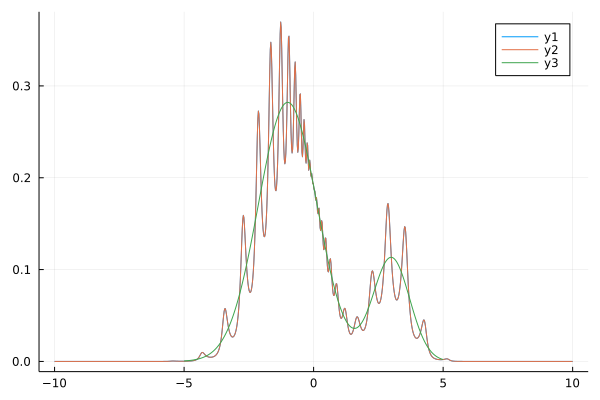

In [41]:
plot(real.(raw_reals.freq), imag.(raw_reals.val)/pi)
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(omegas, rho.(omegas))

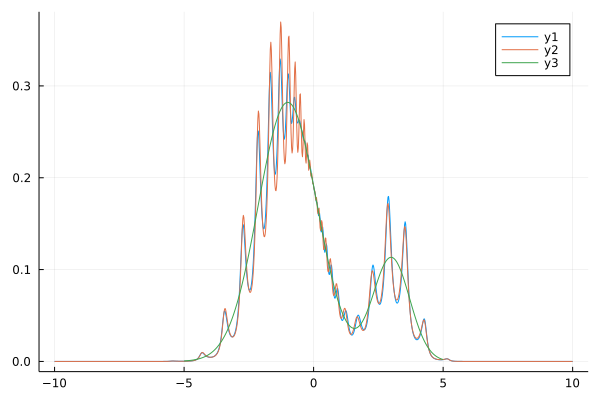

In [38]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [18]:
imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
#noopt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#opt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#noopt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
#opt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
noopt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
opt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
noopt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
opt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, noopt_raw_reals, phis)
ab_coeff  = zeros(ComplexF64, 2*sol.H) 
hardy_matrix = Nevanlinna.calc_hardy_matrix(noopt_raw_reals, sol.H)

Nevanlinna.evaluation!(noopt_raw_reals, abcd, sol.H, ab_coeff, hardy_matrix)
Nevanlinna.evaluation!(opt_raw_reals, abcd, sol.H, sol.ab_coeff, hardy_matrix)

LoadError: MethodError: no method matching RealDomainData(::Int64, ::Float64, ::Float64; T=BigFloat)
[0mClosest candidates are:
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m; T, small_omega, mesh) at ~/work/Nevanlinna_f/src/data.jl:58
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m, [91m::Array{Complex{T}, 1}[39m, [91m::Array{Complex{T}, 1}[39m) where T<:Real at ~/work/Nevanlinna_f/src/data.jl:50[91m got unsupported keyword argument "T"[39m

In [19]:
using FastGaussQuadrature
using OMEinsum
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_green_z(z::Vector{ComplexF64}, xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    newaxis = [CartesianIndex()]
    green_z = ein"q,q,wq->w"(
            quad_rule[2],
            rho.(quad_rule[1]),
            1 ./ (z[:, newaxis] .- quad_rule[1][newaxis, :])
        )
    return green_z
end
#exact_g = calc_green_z(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag])*im*pi/beta, -omega_max, omega_max, 1000)
exact_g = calc_green_z(((collect(1:200).-100)/1000000)*2*pi*im/beta, -omega_max, omega_max, 1000000)

;

┌ Info: Precompiling FastGaussQuadrature [442a2c76-b920-505d-bb47-c5924d526838]
└ @ Base loading.jl:1423
┌ Info: Precompiling OMEinsum [ebe7aa44-baf0-506c-a96f-8464559b3922]
└ @ Base loading.jl:1423


In [20]:
using FastGaussQuadrature
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_sum_omega(xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    sum_omega = 0.0
    for i in 1:deg
        sum_omega += (quad_rule[2] .* rho.(quad_rule[1]))[i]
    end

    return sum_omega
end
sum_o = calc_sum_omega(-omega_max, omega_max, 1000)

0.9999999999999988

In [21]:
exact_g[11]

0.4137527234960012 + 0.3042758217595537im

In [22]:
plot()
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(exact_g)), xlim=[0,0.3],label="real_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-opt_raw_reals.val)), label="real_nopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(exact_g)), xlim=[0,0.01],label="imag_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-opt_raw_reals.val)), label="imag_nopt_dense")

LoadError: UndefVarError: noopt_raw_reals not defined

In [23]:
plot()
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-noopt_raw_reals.val-exact_g)), xlim = [0,0.01], label="real_nonopt_dense", xlabel=latexstring("\\omega"), ylabel=latexstring("|\\Delta G(i\\omega_\\nu)|"), yaxis=:log)
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-opt_raw_reals.val-exact_g)), label="real_opt_dense")

LoadError: UndefVarError: noopt_raw_reals not defined

In [24]:
#plot()
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(exact_g)), label="real_exact", xlabel=latexstring("\\nu"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-opt_raw_reals.val)), label="real_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(real.(test_gw[1:N_imag])), label="real_sparse")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(exact_g)), label="imag_exact")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-opt_raw_reals.val)), label="imag_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(imag.(test_gw[1:N_imag])), label="imag_sparse")

In [25]:
#plot()
#plot(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-noopt_raw_reals.val.-exact_g)), yaxis=:log, label="abs_nonopt_dense", xlabel=latexstring("\\nu"), ylabel=latexstring("\\Delta |G(i\\omega_\\nu)|"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-opt_raw_reals.val-exact_g)), label="abs_opt_dense")

In [26]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [27]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#